# 使用torchvision的数据集

In [54]:
import mlearn as mlearn
from mlearn import functional as F
from mlearn import layers
from mlearn.optimizers import SGD, RMSProp, Momentum
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from mlearn.utils import DataLoader
from mlearn.utils import pre_F as P
import sys
from time import time

# 加载数据集

In [28]:
train = datasets.FashionMNIST("datasets", train=True, download=True)

test = datasets.FashionMNIST("datasets", train=False, download=True)

pre = [P.normalize_MinMax]
trainset = DataLoader((train.data,train.targets),batch_size=32,shuffle=True,
                      preprocessing=pre)
testset = DataLoader((test.data, test.targets), batch_size=32, shuffle=True,
                    preprocessing=pre)

In [36]:
class Net(mlearn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.dense1 = layers.Dense(784,300)
        self.dense2 = layers.Dense(300,10)
        
    def forward(self, inputs):
        o = self.dense1(inputs)
        o = F.relu(o)
        o = self.dense2(o)
        o = F.relu(o)
        return o
net = Net()

In [56]:
def train():
    hist = []
    optimizer = SGD(net,0.01)
    EPOCHS = 5
    net.zero_grad()
    start = time()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        bar = " "*20
        for i, batch in enumerate(trainset, 0):
            
            features, labels = batch
            net.zero_grad()
            predict = net(features.reshape(-1,784))
            loss = F.cross_entropy(predict, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data
            # 禁用 io可以提升一倍的訓練速度
            print(f"\r{epoch+1}/{EPOCHS} Batch %-4d/1874  [{bar}] -> AVG Loss %.5f"%(i,running_loss/(i+1)), end="")
            sys.stdout.flush()
        print()
        hist.append(running_loss/(i+1))
    print(f"Finished in {time() - start}")
    print('trainning completed!')
    return np.array(hist)
hist = train()

1/5 Batch 1874/1874  [                    ] -> AVG Loss 0.19994
2/5 Batch 1874/1874  [                    ] -> AVG Loss 0.19761
3/5 Batch 1874/1874  [                    ] -> AVG Loss 0.19533
4/5 Batch 1874/1874  [                    ] -> AVG Loss 0.19304
5/5 Batch 1874/1874  [                    ] -> AVG Loss 0.19088
Finished in 48.939802169799805
trainning completed!


In [ ]:
# Finished in 21.088968515396118

In [50]:
correct = 0
total = 0

for batch in testset:
    features, labels = batch
    o = net(features.reshape(-1,784))
    predict = []
    for x in o.data:
        predict.append(np.argmax(x))
    for b in predict == labels.data:
        if b:
            correct += 1
    total += 32
print("Accuracy %.5f"%(correct / total))

Accuracy 0.88299


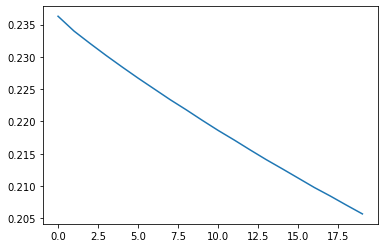

In [51]:
plt.plot(hist)
plt.show()